In [6]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
import pandas as pd
from pathlib import Path
from typing import Dict

import matplotlib
matplotlib.rcParams.update({'font.size': 18})

import sys
sys.path.append("..")
from main import get_output_nodes

In [7]:
nodes = ['AOD', 'CarbonMonoxide', 'FIRE', 'LAI', 'LSTD_AN', 'LSTN_AN', 'WV']
print(nodes)


['AOD', 'CarbonMonoxide', 'FIRE', 'LAI', 'LSTD_AN', 'LSTN_AN', 'WV']


In [8]:
def rel(baseline, x):
    return ((baseline / x) - 1) * 100

def rel_std(baseline_l2, baseline_std, x_l2, x_std):
    # print(baseline_l2, baseline_l2, x_l2, x_std)
    x_rel = rel(baseline_l2, x_l2)
    A = rel(baseline_l2 - baseline_std, x_l2 - x_std) - x_rel
    B = -rel(baseline_l2 + baseline_std, x_l2 + x_std) + x_rel
    return abs((A + B) / 2)

def get_it1_sl_score(node: str, it1_dir) -> pd.Series:
    edges = pd.read_csv(f"{it1_dir}/{node}_results_edges_test.csv")
    edges = edges[edges["edges"].str.contains("Single Link")]
    edges = edges.set_index("edges")
    res = edges.iloc[0]
    return res[["l2", "l2_std"]]

def get_it2_sl_score(node: str, it2_dir, it1_sl_score: pd.Series) -> pd.Series:
    edges = pd.read_csv(f"{it2_dir}/{node}_results_edges_test.csv", index_col=0)
    it2_sl_score = edges.loc[it1_sl_score.name]
    return it2_sl_score[["l2", "l2_std"]]

def f_plot(ax, key_values: Dict[str, pd.DataFrame], plot_kwargs: Dict={}, fig_kwargs: Dict={}):
    """Plot one node's data for all ensembles"""
    def _errorbar(ax, x, y, yerr, **kwargs):
        ax.errorbar(x, y, yerr, **kwargs, alpha=.75, fmt=':', capsize=3, capthick=1)
        data = {
            'x': x,
            'y1': [y - e for y, e in zip(y, yerr)],
            'y2': [y + e for y, e in zip(y, yerr)]}
        ax.fill_between(**data, **kwargs, alpha=.05)
        # ax.plot(x, data["y1"], "--", **kwargs)
        # ax.plot(x, data["y2"], "--", **kwargs)

    colors = plot_kwargs.pop("colors") if "colors" in plot_kwargs else 100 * [None]
    labels = plot_kwargs.pop("labels") if "labels" in plot_kwargs else 100 * [None]
    errorbar = plot_kwargs.pop("errorbar") if "errorbar" in plot_kwargs else False
    i = 0
    for method, v in key_values.items():
        y, yerr = v["l2 relative"], v["l2 relative std"]
        x = range(len(y))
        ax.plot(y, **plot_kwargs, color=colors[i], label=labels[i])
        if errorbar:
            _errorbar(ax, x, y, yerr, color=colors[i])
        i += 1

    ax.plot([0, 0, 0], "-", color="black")
    ax.set_title(fig_kwargs.get("title", None))
    ax.set_ylim(fig_kwargs.get("ylim", None))
    default_xticks = [range(len(key_values))]
    ax.set_xticks(*fig_kwargs.get("xticks", default_xticks))
    ax.set_xlabel(fig_kwargs.get("xlabel", "Iteration"))
    ax.set_ylabel(fig_kwargs.get("ylabel", "Relative improvement (%)"))
    if fig_kwargs.get("legend", False):
        ax.legend()


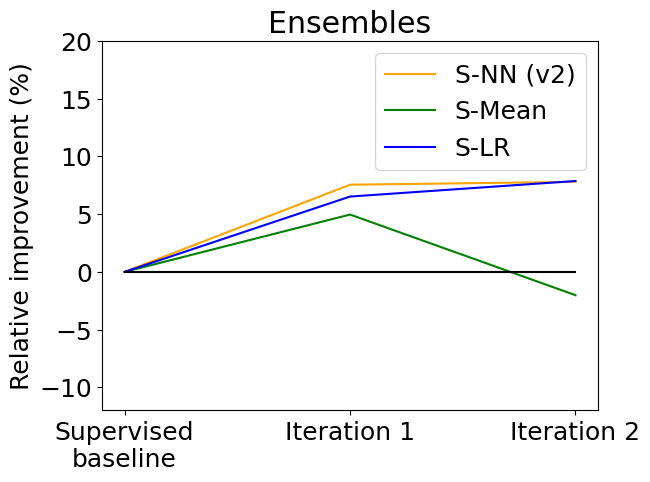

In [9]:
paths = {
    "nn_small_v2": [
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa/iterative_training/dump_dir_it1_train",
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa/iterative_training/dump_dir_it1_train",
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa/iterative_training/dump_dir_it2_nn_train",
    ],
    "simple_mean": [
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa/iterative_training/dump_dir_it1_train",
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa/iterative_training/dump_dir_it1_train",
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa/iterative_training/dump_dir_it2_mean_train",
    ],
    "weighted_mean_lr": [
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa/iterative_training/dump_dir_it1_train",
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa/iterative_training/dump_dir_it1_train",
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa/iterative_training/dump_dir_it2_lr_train",
    ]
}

def read_ens_data(paths, node):
    res = {}
    for i, (variant, path) in enumerate(paths.items()):
        this_df = []
        baseline = get_it1_sl_score(node, path[0])
        this_df.append(baseline)

        in_file = f"{path[1]}/{node}_results_{variant}.csv"
        this_df.append(pd.read_csv(in_file, index_col=0).iloc[0])

        in_file = f"{path[2]}/{node}_results_{variant}.csv"
        this_df.append(pd.read_csv(in_file, index_col=0).iloc[0])

        this_df = pd.DataFrame(this_df)
        this_df["l2 relative"] =  rel(baseline["l2"], this_df["l2"])
        this_df["l2 relative std"] = rel_std(baseline["l2"], baseline["l2_std"], this_df["l2"], this_df["l2_std"])

        this_df = this_df[["l2", "l2_std", "l2 relative", "l2 relative std"]]

        this_df.index = 0, 1, 2

        res[variant] = this_df
    return res

def rel_std(baseline_l2, baseline_std, x_l2, x_std):
    # print(baseline_l2, baseline_l2, x_l2, x_std)
    x_rel = rel(baseline_l2, x_l2)
    A = rel(baseline_l2 - baseline_std, x_l2 - x_std) - x_rel
    B = -rel(baseline_l2 + baseline_std, x_l2 + x_std) + x_rel
    return abs((A + B) / 2)

def get_average_across_nodes(nodes_data: Dict[str, NDArray["n_iter,avg_val_per_iter"]]) -> pd.DataFrame:
    stacked_data = np.stack([x.values for x in nodes_data.values()], axis=0)
    assert stacked_data.shape == (7, 3, 4), f"nodes=7, it=3, l2/ls_std/l2_rel/l2_rel_std vs {stacked_data.shape}"
    columns = nodes_data[list(nodes_data.keys())[0]].columns
    return pd.DataFrame(stacked_data.mean(axis=0), columns=columns)

nodes_ens_data = {node: read_ens_data(paths, node) for node in nodes}
new_data = {method: {node: nodes_ens_data[node][method] for node in nodes_ens_data.keys()} for method in list(nodes_ens_data[nodes[0]].keys())}
avg_data = {method: get_average_across_nodes(data) for method, data in new_data.items()}
# avg_data = {method: v[:, 2:] for method, v in avg_data.items()}
plot_kwargs = {"colors": ["orange", "green", "blue"], "labels": ["S-NN (v2)", "S-Mean", "S-LR"], "errorbar": False}
fig_kwargs = {"title": "Ensembles", "xticks":[[0, 1, 2], ["Supervised\nbaseline", "Iteration 1", "Iteration 2"]],
              "xlabel": None, "legend": True, "ylim": [-12, 20]}
f_plot(plt.figure().gca(), avg_data, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs)


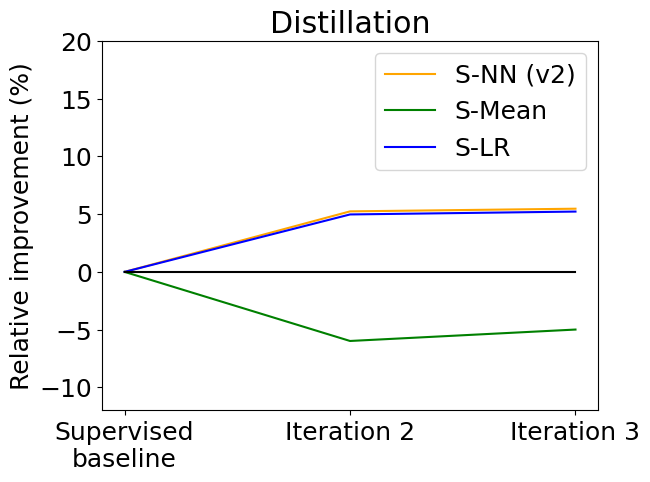

In [11]:
paths = {
    "nn_small_v2": [
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa/iterative_training/dump_dir_it1_train",
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa//iterative_training/dump_dir_it2_nn_train",
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa//iterative_training/dump_dir_it3_nn_test",
    ],
    "simple_mean": [
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa//iterative_training/dump_dir_it1_train",
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa/iterative_training//dump_dir_it2_mean_train",
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa//iterative_training/dump_dir_it3_mean_test",
    ],
    "weighted_mean_lr": [
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa//iterative_training/dump_dir_it1_train",
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa//iterative_training/dump_dir_it2_lr_train",
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa//iterative_training/dump_dir_it3_lr_test",
    ]
}

def read_distil_data(paths, node):
    res = {}
    for i, (variant, path) in enumerate(paths.items()):
        this_df = []
        baseline = get_it1_sl_score(node, path[0])
        this_df.append(baseline)

        in_file = f"{path[1]}/{node}_results_edges_test.csv"
        it2_sl = get_it2_sl_score(node, path[1], baseline)
        this_df.append(it2_sl)

        it3_sl = get_it2_sl_score(node, path[2], baseline)
        this_df.append(it3_sl)

        this_df = pd.DataFrame(this_df)
        this_df["l2 relative"] =  rel(baseline["l2"], this_df["l2"])
        this_df["l2 relative std"] = rel_std(baseline["l2"], baseline["l2_std"], this_df["l2"], this_df["l2_std"])
        this_df = this_df[["l2", "l2_std", "l2 relative", "l2 relative std"]]

        this_df.index = ["baseline", 1, 2]

        res[variant] = this_df
    return res

nodes_distil_data = {node: read_distil_data(paths, node) for node in nodes}
new_data = {method: {node: nodes_distil_data[node][method] for node in nodes_distil_data.keys()} for method in list(nodes_distil_data[nodes[0]].keys())}
avg_data = {method: get_average_across_nodes(data) for method, data in new_data.items()}
# avg_data = {method: v[:, 2:] for method, v in avg_data.items()}
plot_kwargs = {"colors": ["orange", "green", "blue"], "labels": ["S-NN (v2)", "S-Mean", "S-LR"], "errorbar": False}
fig_kwargs = {"title": "Distillation", "xticks":[[0, 1, 2], ["Supervised\nbaseline", "Iteration 2", "Iteration 3"]],
              "xlabel": None, "legend": True, "ylim": [-12, 20]}
f_plot(plt.figure().gca(), avg_data, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs)
